In [1]:
import sys

sys.path.insert(0, "..")
from src.settings import StyleSettings
from src.data.data_tools import StyleDataset
from src.models import rnn

import numpy as np
import seaborn as sns
from typing import Callable, Optional
from torchtext.vocab import Vocab

import gin

In [2]:
settings = StyleSettings()
traindataset = StyleDataset([settings.trainpath])
testdataset = StyleDataset([settings.testpath])


In [3]:
from src.models import tokenizer

corpus = []
for i in range(len(traindataset)):
    x = tokenizer.clean(traindataset[i][0])
    corpus.append(x)
v = tokenizer.build_vocab(corpus, max=20000)
len(v)

2022-06-26 13:16:40.373 | INFO     | src.models.tokenizer:build_vocab:27 - Found 19306 tokens


19308

In [4]:
# TODO ~ about 4 lines of code
class StylePreprocessor(tokenizer.Preprocessor):
    def __init__(self, max: int, vocab: Vocab, clean: Optional[Callable]) -> None:
        super().__init__(max, vocab, clean)

    def cast_label(self, label: str) -> int:
        d = {"humor": 0, "reuters": 1, "wiki": 2, "proverbs": 3}
        return d[label]


In [5]:
max_lenght = 50
preprocessor = StylePreprocessor(max=max_lenght, vocab=v, clean=tokenizer.clean)


In [6]:
from src.data import data_tools

trainstreamer = data_tools.BaseDatastreamer(
    dataset=traindataset, batchsize=32, preprocessor=preprocessor
).stream()
teststreamer = data_tools.BaseDatastreamer(
    dataset=testdataset, batchsize=32, preprocessor=preprocessor
).stream()

x, y = next(trainstreamer)
x.shape, y

(torch.Size([32, 48]),
 tensor([2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 0, 1, 1, 2, 0, 0, 1, 2, 3, 1, 1,
         2, 2, 0, 0, 0, 1, 2, 2]))

In [7]:
import trax

def Cast():
    "Adding padding to sequences, as the trax model doesn't allow for different sequence lengths"
    def f(generator, max_len = max_lenght):
        for x, y in generator:
            new_x = []
            _x = x.numpy()
            for i in range(len(_x)):
                array = _x[i]
                new_x.append(np.pad(array, (0, max_len - len(array))))
            yield np.array(new_x), y.numpy()
    return lambda g: f(g)


data_pipeline = trax.data.Serial(Cast())
trainpipe = data_pipeline(trainstreamer)
testpipe = data_pipeline(teststreamer)
X, y = next(trainpipe)
type(X), type(y)

2022-06-26 13:16:42.161501: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


(numpy.ndarray, numpy.ndarray)

In [13]:
from trax.shapes import signature
from src.models import rnnTrax

gin.parse_config_file("model.gin")

config = {
    "vocab": len(v),
    "hidden_size": 128,
    "num_layers": 3,
    "dropout": 0.1,
    "output_size": 4,
}

model = rnnTrax.NLPTraxCausalAttentionOneGruLast()

model.init_weights_and_state(signature(X))


In [14]:
from trax.supervised.lr_schedules import constant

lr = constant(1e-3)

In [15]:
from trax.supervised.lr_schedules import warmup_and_rsqrt_decay

lr = warmup_and_rsqrt_decay(100, 0.01)

In [16]:
from trax.supervised import training
from trax import layers as tl
from src.models import metrics

def train_model(steps):
    log_dir = settings.log_dir
    log_dir = data_tools.dir_add_timestamp(log_dir)

    train_task = training.TrainTask(
        labeled_data=trainpipe,
        loss_layer=tl.CategoryCrossEntropy(),
        optimizer=trax.optimizers.Adam(),
        lr_schedule=lr
    )

    eval_task = training.EvalTask(
        labeled_data=testpipe, metrics=[tl.CategoryAccuracy(), tl.WeightedFScore(), tl.CategoryCrossEntropy()], n_eval_batches=25
    )

    loop = training.Loop(
        model,
        train_task,
        eval_tasks=[eval_task],
        output_dir=log_dir,
    )
    loop.run(steps)

In [17]:
train_model(3000)

2022-06-26 13:18:32.957 | INFO     | src.data.data_tools:dir_add_timestamp:66 - Logging to ../tune/20220626-1318
/home/mladmin/.cache/pypoetry/virtualenvs/exam-22-QTUf-Kx1-py3.9/lib/python3.9/site-packages/jax/_src/lib/xla_bridge.py:514: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  warnings.warn(
/home/mladmin/.cache/pypoetry/virtualenvs/exam-22-QTUf-Kx1-py3.9/lib/python3.9/site-packages/trax/layers/base.py:851: FutureWarning: GzipFile was opened for writing, but this will change in future Python releases.  Specify the mode argument for opening it for writing.
  with gzip.GzipFile(fileobj=f, compresslevel=compresslevel) as gzipf:



Step      1: Total number of trainable weights: 2636676
Step      1: Ran 1 train steps in 6.62 secs
Step      1: train CategoryCrossEntropy |  1.38352680


/home/mladmin/.cache/pypoetry/virtualenvs/exam-22-QTUf-Kx1-py3.9/lib/python3.9/site-packages/trax/supervised/training.py:1249: FutureWarning: GzipFile was opened for writing, but this will change in future Python releases.  Specify the mode argument for opening it for writing.
  with gzip_lib.GzipFile(fileobj=f, compresslevel=2) as gzipf:


Step      1: eval      CategoryAccuracy |  0.31625000
Step      1: eval        WeightedFScore |  0.15845168
Step      1: eval  CategoryCrossEntropy |  1.38357815

Step    100: Ran 99 train steps in 8.67 secs
Step    100: train CategoryCrossEntropy |  1.06037641
Step    100: eval      CategoryAccuracy |  0.80375000
Step    100: eval        WeightedFScore |  0.78675003
Step    100: eval  CategoryCrossEntropy |  0.57789233

Step    200: Ran 100 train steps in 9.20 secs
Step    200: train CategoryCrossEntropy |  0.44918513
Step    200: eval      CategoryAccuracy |  0.86875000
Step    200: eval        WeightedFScore |  0.84766730
Step    200: eval  CategoryCrossEntropy |  0.34646960

Step    300: Ran 100 train steps in 8.36 secs
Step    300: train CategoryCrossEntropy |  0.31935063
Step    300: eval      CategoryAccuracy |  0.90125000
Step    300: eval        WeightedFScore |  0.90178746
Step    300: eval  CategoryCrossEntropy |  0.29950951

Step    400: Ran 100 train steps in 8.19 secs
Ste

BEVINDINGEN

In trax heb ik eerst een base model gemaakt, met een embedding laag, GRU laag, dropout laag, hier nemen we vervolgens de laatste hidden state van, die wordt gevoed aan de dense laag (zie rnnTrax - BaseNLPTrax). De geselecteerde trax metrics zijn categorical accuracy en WeightedFScore. Dit model, met één GRU laag haalt na 3000 trainingsstappen een weightedFScore behaald van 89%, dat is beter dan het Pytorch model met 2 of 3 lagen! In de tensorboard afbeeldingen is te zien dat het model eerst door alle trainingsvoorbeelden gaat, hier blijft loss/accuraatheid nog horizontaal. Vervolgens, na 1500 stappen begint het model te leren, de loss neemt af en F score neemt snel toe. 

Vervolgens is het model aangepast naar 2 GRU lagen, beide opgevolgd door een Dropout laag. Dit model begint pas veel later te leren (na 5000 trainingsstappen). Het model bereikt gelijke accuraatheid als het model met één GRU laag. 

In plaats van het nemen van de laatste hidden state van de GRU, kunnen we ook het gemiddelde van de hidden states nemen. Wanneer dit model gerunt wordt, traint het model gelijk vanaf de eerste stap. Dit model met één laag bereikt na 3000 stappen een fscore van 85%. Hetzelfde model met 2 GRU lagen bereikt een Fscore van 87%. Dit is dus al beter, maar nog steeds minder goed als het toepassen van de "Last" layer. Ook de test loss van het model met de AvgLast layer blijft iets achter bij de test loss van het model met Last layer. Bij de afweging tussen deze twee modellen is ook de prioritering trainingstijd vs accuraatheid belangrijk.

Vervolgens wordt het aantal units vergroot van 128 naar 256. Dit model bereikt erg snel een hoge accuraatheid, maar accuraatheid neemt na 1000 stappen (84%) bijna niet meer toe (model eindigd op 86%). Het model overtraint wel.

Voor bovenstaande modellen wordt nog een constante learning rate gebruikt. Nu willen we een variabele learning rate toepassen. Een mogelijkheid hiertoe is het gebruiken van de warm-up decay scheduler. Hieronder is te zien hoe het schema van deze scheduler er uit ziet. Het model begint met een lage learning rate, deze neemt vervolgens heel snel toe en neemt dan langzaam af. Het model wordt gerunt met 3000 trainingsstappen, en outperformed alle voorgaande modellen. Een Fscore van 90% wordt behaald. Wel overtraind het model opnieuw, te zien aan de toenemende test loss en nog steeds afnemende train loss.

Wellicht zou het toevoegen van een attention layer nog wat extra intelligentie toevoegen aan het model. Dit model is genoemd "NLPTraxCausalAttention". Er is een CausalAttention layer toegevoegd. De causal attention laag is een variatie op de normale Attention layer welke tracht de bias van de normale attention layer naar onterechte correlaties in de training data weg te halen. Deze bias zorgt in de normale attention layer voor minder generaliseerbaarheid van het model. Het toevoegen van de attention layer heeft een klein positief effect op de Fscore (91%).

Vervolgens heb ik de 2e GRU layer uit het model gehaald, omdat het model "NLPTraxCausalAttention" aan het overtrainen was (te zien aan de test loss). Wellicht is het model te complex. Dit lijkt inderdaad te werken, de loss wordt sneller kleiner, maar dit model moet niet te lang doorgetraind worden omdat het dan wel weer gaat overtrainen (1500 stappen is voldoende). Dit zorgde ook voor een verbetering van de Fscore naar 92%.

Als laatste test nog de avglast() layer aangepast naar de last() layer. In de architectuur met 1 GRU en een Causal attention layer komt deze beter tot zijn recht. De Fscore verbeterd weer iets (93%), en ook neemt de loss sneller af.

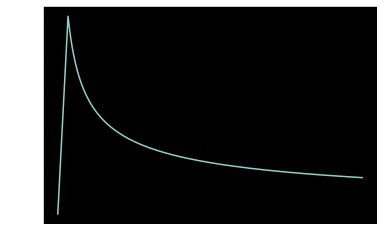

In [16]:
from trax.supervised.lr_schedules import warmup_and_rsqrt_decay
import jax.numpy as jnp

from matplotlib import pyplot as plt
plt.style.use("dark_background")
%matplotlib inline


lr = warmup_and_rsqrt_decay(100, 0.01)
steps = jnp.arange(3000)
y = [lr(x) for x in steps]
plt.plot(steps, y)
